In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

In [2]:
def get_dataset(d, n_train, n_test):
  x_train = np.random.randn(n_train, d)
  x_test = np.random.randn(n_test, d)
  mean_train = np.empty(d)
  norm_tab = np.empty(n_train)

  norm_train = (np.sum(x_train * x_train, axis = 1) ** 0.5).reshape(n_train, 1)
  x_train = (x_train / norm_train) * (d ** 0.5)
      
  norm_test = (np.sum(x_test * x_test, axis = 1) **0.5).reshape(n_test, 1)
  x_test = (x_test / norm_test) * (d**0.5)

  #On vérifie que notre data set soit uniforme (sur chaque dimension, le dataset a à peu près une moyenne de 0)
  #On se rapproche de plus en plus de 0 lorsqu'on augmente n_train, les données étant mieux réparties
  mean_train = np.sum(x_train, axis = 0) / n_train
      
  #On vérifie que chaque élément de notre dataset ait une norme de sqrt(d)
  norm_tab = np.sum(x_train * x_train, axis = 1) ** 0.5
      
  tau = 0.1 
  noise_level = tau * tau

  F1 = 1

  sample_params = np.random.randn(d, 1)
      
  norm = np.sum(sample_params * sample_params) #should be equal to F1^2
  sample_params = sample_params * (F1 / (norm**0.5))

  #On veut E(noise) == 0 et E(noise^2) == tau^2
  noise_train = np.random.randn(n_train, 1) * noise_level
  noise_test = np.random.randn(n_test, 1) * noise_level

  y_train = np.dot(x_train, sample_params) + noise_train
  y_test = np.dot(x_test, sample_params) + noise_test

  return x_train, y_train, x_test, y_test

In [3]:
#Quelques fonctions d'activation :

class Sigmoid :
    @staticmethod
    def function(x):
        return 1/(1+np.exp(-x))
    
    @staticmethod
    def gradient(x):
        return Sigmoid.function(x) * Sigmoid.function(-x)
    
class Tanh :
    @staticmethod
    def function(x):
        return np.tanh(x)
        
    @staticmethod
    def gradient(x):
        t = Tanh.function(x)
        return 1-t**2
    
class Relu :
    @staticmethod
    def function(x):
        return x * (x > 0)
    
    @staticmethod
    def gradient(x):
        return x >= 0

class Linear :
    @staticmethod
    def function(x):
        return x
    
    @staticmethod
    def gradient(x):
        return np.ones((x.shape[0], x.shape[1]))

In [4]:
#Quelques Loss Functions :
class MSE:
    @staticmethod
    def loss(y_real, y_hat):
        return np.mean(np.sum((y_hat.T - y_real.T)**2, axis = 0))    
    
    @staticmethod
    def gradient(y_real, y_hat):
        return (2/y_real.shape[0]) * (y_hat - y_real)

In [5]:
#L'architecture

class Network:
    def __init__(self, dimension_hidden, activation1, activation2):
        """
        dimension_hidden est le nombre de paramètres dans le hidden layer (N dans le papier de Mei et Montanari)
        activation1 est la fonction d'activation du hidden layer
        activation2 est la fonction d'activation de l'output layer
        """
        
        self.nb_layers = 3 #input, hidden, output
        self.dimensions = (d, dimension_hidden, 1)
                
        self.learning_rate = {}
        self.learning_rate[1] = None;  #learning rate du hidden layer
        self.learning_rate[2] = None;  #learning rate du output layer
        
        self.weights = {}
        self.bias = {}
        
        #on initialise les weights et les bias aléatoirement
        for i in range(1, self.nb_layers):
            self.weights[i] = np.random.randn(self.dimensions[i - 1], self.dimensions[i]) / np.sqrt(self.dimensions[i - 1])
            self.bias[i] = np.zeros(self.dimensions[i])
         
        self.activations = {}
        self.activations[2] = activation1
        self.activations[3] = activation2
        
    def forward_pass(self, x):
        """
        x est un vecteur de notre data
        
        return : z contient les paramètres avant que l'on applique l'activation function
        return : a contient les paramètres après que l'on applique l'activation function
        """
        z = {}
        a = {1:x} #l'input layer n'a pas d'activation function, a[1] est donc égal à x
        for i in range(1, self.nb_layers):
            z[i + 1] = np.dot(a[i], self.weights[i]) + self.bias[i] #Z = XW + b
            a[i + 1] = self.activations[i + 1].function(z[i + 1])
            
        return z, a
    
    def predict(self, x):
        _, a = self.forward_pass(x)
        return a[self.nb_layers]
    
    def back_propagation(self, z, a, y_real):
        y_hat = a[self.nb_layers]
        #On calcule delta et la dérivée partielle à l'output layer
        delta = self.loss_function.gradient(y_real, y_hat) * self.activations[self.nb_layers].gradient(y_hat)
        partial_deriv = np.dot(a[self.nb_layers - 1].T, delta)
     
        update_parameters = {
            self.nb_layers - 1: (partial_deriv, delta)
        }
        
        
        #On calcule delta et la dérivée partielle à l'hidden layer
        delta = np.dot(delta, self.weights[2].T) * self.activations[2].gradient(z[2])
        partial_deriv = np.dot(a[1].T, delta) 
        update_parameters[1] = (partial_deriv, delta)
            
        for k, v in update_parameters.items():
            self.update_weights_and_bias(k, v[0], v[1])
            
    def update_weights_and_bias(self, index, partial_deriv, delta):
        self.weights[index] -= self.learning_rate[index] * partial_deriv
        self.bias[index] -= self.learning_rate[index] * np.mean(delta, 0)

    def fit(self, x, y_real, x_test, y_test, loss, nb_iterations = 100, batch_size = 100, learning_rate1 = 0, learning_rate2 = 0.3):
        #On vérifie qu'on a autant de x que de y
        if not (x.shape[0] == y_real.shape[0]):
            raise Exception
            
        loss_tab = []
        
        self.loss_function = loss
        self.learning_rate[1] = learning_rate1
        self.learning_rate[2] = learning_rate2
        
        #We use batch gradient descent
        for i in range(nb_iterations):
            for j in range(x.shape[0] // batch_size):
                start = j * batch_size
                end = (j + 1) * batch_size
                z, a = self.forward_pass(x[start:end])
                self.back_propagation(z, a, y_real[start:end])
            _, a_train = self.forward_pass(x)
            _, a_test = self.forward_pass(x_test)
            loss_tab.append({
                "train_mse":  self.loss_function.loss(y_real, a_train[self.nb_layers]),
                "test_mse":  self.loss_function.loss(y_test, a_test[self.nb_layers]),
            })
            if(i % 50) == 0:
                print(f"Loss at Iteration {i} for first batch is {loss_tab[-1]}")
        return loss_tab

In [6]:
d = 300
n_train = 100
n_test = 100

N_SPACE = np.arange(0, 600, 50)

l = []

for i, N in enumerate(N_SPACE):
  print(f"progress {100*i/len(N_SPACE):.2f}%")
  l0 = []
  for _ in range(10):
    x_train, y_train, x_test, y_test = get_dataset(d, n_train, n_test)

    nn = Network(N, Relu, Linear)
    config = dict(
        nb_iterations=100, 
        batch_size=100, 
        learning_rate1=0.00, 
        learning_rate2=0.01
    )
    history = nn.fit(x_train, y_train, x_test, y_test, MSE, **config)
    test_prediction = nn.predict(x_test)
    final_test_error = nn.loss_function.loss(y_test, test_prediction)
    l0.append(final_test_error)
    print(final_test_error)
  l0 = np.array(l0)
  l.append({"mean": l0.mean(), "std": l0.std()})


progress 0.00%
Loss at Iteration 0 for first batch is {'train_mse': 1.0792390343906373, 'test_mse': 1.2811593202152824}
Loss at Iteration 50 for first batch is {'train_mse': 1.079233505023173, 'test_mse': 1.2812200907248905}
1.281279111932807
Loss at Iteration 0 for first batch is {'train_mse': 0.8642590885757186, 'test_mse': 0.8102901440412164}
Loss at Iteration 50 for first batch is {'train_mse': 0.864233435218036, 'test_mse': 0.8103117264828766}
0.8103329141492543
Loss at Iteration 0 for first batch is {'train_mse': 0.8913918375393456, 'test_mse': 1.2729417676058943}
Loss at Iteration 50 for first batch is {'train_mse': 0.8912412017626166, 'test_mse': 1.2730917659801815}
1.2732387562595868
Loss at Iteration 0 for first batch is {'train_mse': 0.9053641278249475, 'test_mse': 0.8918790611178835}
Loss at Iteration 50 for first batch is {'train_mse': 0.9053272786998201, 'test_mse': 0.8918353643027568}
0.8917933156218111
Loss at Iteration 0 for first batch is {'train_mse': 1.0007793154442

Loss at Iteration 50 for first batch is {'train_mse': 0.41669864279098734, 'test_mse': 1.2973341428306089}
1.3399551468994946
Loss at Iteration 0 for first batch is {'train_mse': 1.2704210507410756, 'test_mse': 1.405195326818297}
Loss at Iteration 50 for first batch is {'train_mse': 0.49875842928992115, 'test_mse': 1.2475658734554853}
1.2544410833982338
Loss at Iteration 0 for first batch is {'train_mse': 1.6632473776263705, 'test_mse': 1.7614172367496495}
Loss at Iteration 50 for first batch is {'train_mse': 0.6323609730565388, 'test_mse': 1.2430329988380393}
1.2450396199985678
progress 33.33%
Loss at Iteration 0 for first batch is {'train_mse': 1.3993883388413808, 'test_mse': 1.3475423836494749}
Loss at Iteration 50 for first batch is {'train_mse': 0.37205649640438665, 'test_mse': 1.1953096809153987}
1.198748142513147
Loss at Iteration 0 for first batch is {'train_mse': 1.2481448291473412, 'test_mse': 1.3283900504964345}
Loss at Iteration 50 for first batch is {'train_mse': 0.4298504

1.3135902237218062
Loss at Iteration 0 for first batch is {'train_mse': 1.1033137965723474, 'test_mse': 1.3901270575192723}
Loss at Iteration 50 for first batch is {'train_mse': 0.14526129328353005, 'test_mse': 1.1843980372128922}
1.222705145851544
Loss at Iteration 0 for first batch is {'train_mse': 0.9507424515198794, 'test_mse': 1.6317048825164435}
Loss at Iteration 50 for first batch is {'train_mse': 0.14398167702003353, 'test_mse': 1.408566793704719}
1.3962215955784147
Loss at Iteration 0 for first batch is {'train_mse': 1.3624566237887419, 'test_mse': 1.4536633670895904}
Loss at Iteration 50 for first batch is {'train_mse': 0.22941511286265878, 'test_mse': 1.194225027396581}
1.1807976979135644
Loss at Iteration 0 for first batch is {'train_mse': 1.4233464975095043, 'test_mse': 1.6087567539422158}
Loss at Iteration 50 for first batch is {'train_mse': 0.18402862934134037, 'test_mse': 1.308248202619977}
1.2853378784776746
Loss at Iteration 0 for first batch is {'train_mse': 1.531953

Loss at Iteration 50 for first batch is {'train_mse': 0.07157930879890433, 'test_mse': 1.0446344820535074}
1.0703706088220002
Loss at Iteration 0 for first batch is {'train_mse': 1.3950458867973663, 'test_mse': 1.897036165489257}
Loss at Iteration 50 for first batch is {'train_mse': 0.07148116099076565, 'test_mse': 1.4855472190736014}
1.4824727105715099
progress 91.67%
Loss at Iteration 0 for first batch is {'train_mse': 1.2842066440854558, 'test_mse': 1.0725683794232983}
Loss at Iteration 50 for first batch is {'train_mse': 0.07549238172558292, 'test_mse': 0.9086562035785037}
0.9101025683024493
Loss at Iteration 0 for first batch is {'train_mse': 1.5987139168188202, 'test_mse': 1.5674997670861286}
Loss at Iteration 50 for first batch is {'train_mse': 0.08251729094803326, 'test_mse': 1.0811006310297993}
1.078380938519854
Loss at Iteration 0 for first batch is {'train_mse': 1.5215422905357137, 'test_mse': 1.6174350036704386}
Loss at Iteration 50 for first batch is {'train_mse': 0.052257

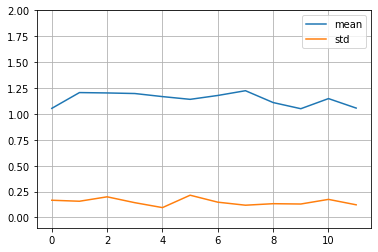

In [7]:
df = pd.DataFrame(l)
df.plot(grid=True)
mpl.ylim(-0.1, 2)
mpl.show()

In [8]:
pd.DataFrame(l)

,mean,std
0,1.053538,0.166176
1,1.205967,0.156461
2,1.202387,0.199249
3,1.196825,0.142602
4,1.167138,0.095058
5,1.140646,0.214745
6,1.178100,0.147432
7,1.224021,0.118230
8,1.109573,0.132817
9,1.050130,0.129707


In [9]:
history

[{'train_mse': 1.356091022501976, 'test_mse': 1.7694635131968333},
 {'train_mse': 1.2017890877793052, 'test_mse': 1.3442425971786411},
 {'train_mse': 1.0738499783416875, 'test_mse': 1.5669696000525695},
 {'train_mse': 0.9662900679887837, 'test_mse': 1.2832309091898637},
 {'train_mse': 0.8747109710444577, 'test_mse': 1.435385762111958},
 {'train_mse': 0.7958476583682813, 'test_mse': 1.2429304041682685},
 {'train_mse': 0.7272498073118777, 'test_mse': 1.345072605593181},
 {'train_mse': 0.6670564661990571, 'test_mse': 1.2125356179904323},
 {'train_mse': 0.6138361714165977, 'test_mse': 1.2798807974364534},
 {'train_mse': 0.5664730552344565, 'test_mse': 1.18726046834139},
 {'train_mse': 0.5240853370815636, 'test_mse': 1.2307133008876985},
 {'train_mse': 0.4859666736677973, 'test_mse': 1.1650285159638982},
 {'train_mse': 0.4515436921355118, 'test_mse': 1.192249059311383},
 {'train_mse': 0.4203450197193924, 'test_mse': 1.144949172275593},
 {'train_mse': 0.3919785137238452, 'test_mse': 1.161247